# IMPORTAÇÃO DAS BIBLIOTECAS

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from imblearn import over_sampling, under_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore")

# IMPORTAÇÃO DOS DADOS

In [10]:
weather = pd.read_csv("../../DATA/weatherAUS.csv")
weather = (
    weather.sort_values(by=["Date", "Location"], ascending=True)
    .drop(
        columns=[
            "RainToday",
            "Pressure9am",
            "Temp9am",
            "Temp3pm",
            "WindDir9am",
            "Location",
        ]
    )
    .dropna()
)
weather.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainTomorrow
45587,2007-11-01,8.0,24.3,0.0,3.4,6.3,NW,30.0,NW,6.0,20.0,68.0,29.0,1015.0,7.0,7.0,Yes
45588,2007-11-02,14.0,26.9,3.6,4.4,9.7,ENE,39.0,W,4.0,17.0,80.0,36.0,1008.4,5.0,3.0,Yes
45589,2007-11-03,13.7,23.4,3.6,5.8,3.3,NW,85.0,NNE,6.0,6.0,82.0,69.0,1007.2,8.0,7.0,Yes
45590,2007-11-04,13.3,15.5,39.8,7.2,9.1,NW,54.0,W,30.0,24.0,62.0,56.0,1007.0,2.0,7.0,Yes
45591,2007-11-05,7.6,16.1,2.8,5.6,10.6,SSE,50.0,ESE,20.0,28.0,68.0,49.0,1018.5,7.0,7.0,No


# PROCESSAMENTO DE DADOS

## FORMATO DE DADOS

In [11]:
weather["Date"] = pd.to_datetime(weather["Date"], format="%Y-%m-%d")
weather["RainTomorrow"] = weather.RainTomorrow.map({"Yes": 1, "No": 0})

## VARIÁVEIS CATEGÓRICAS

In [12]:
categorical_columns = weather.select_dtypes(include=["object", "datetime64"])
numerical_columns = weather.select_dtypes("number")

In [13]:
print(
    "WindGustDir contains", len(categorical_columns["WindGustDir"].unique()), "labels"
)
print("WindDir3pm contains", len(categorical_columns["WindDir3pm"].unique()), "labels")

WindGustDir contains 16 labels
WindDir3pm contains 16 labels


### DUMMIES

In [14]:
categorical_encoded = pd.get_dummies(
    categorical_columns,
    columns=["WindGustDir", "WindDir3pm"],
    drop_first=True,
    prefix=["WindGustDir", "WindDir3pm"],
    dtype=int,
)

## VARIÁVEIS NUMÉRICAS

In [15]:
numerical_columns["RangeTemp"] = (
    numerical_columns["MaxTemp"] - numerical_columns["MinTemp"]
)

In [16]:
discretizer = KBinsDiscretizer(
    n_bins=5, encode="ordinal", strategy="kmeans", random_state=42
)
numerical_columns["Rainfall_Discretized"] = discretizer.fit_transform(
    numerical_columns["Rainfall"].values.reshape(-1, 1)
)
numerical_columns.groupby("Rainfall_Discretized")["Rainfall"].agg(
    ["min", "max"]
).reset_index()

,Rainfall_Discretized,min,max
0,0.0,0.0,4.4
1,1.0,4.5,15.2
2,2.0,15.4,33.6
3,3.0,33.8,71.8
4,4.0,74.6,206.2


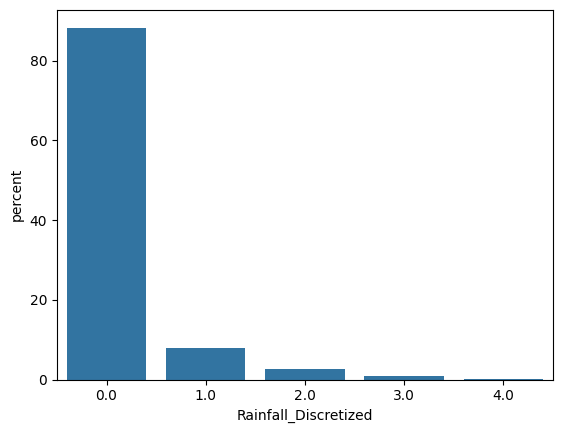

In [9]:
sns.countplot(numerical_columns, x="Rainfall_Discretized", stat="percent");

In [10]:
numerical_columns.Rainfall_Discretized.value_counts().to_frame("QTD").reset_index()

,Rainfall_Discretized,QTD
0,0.0,51174
1,1.0,4580
2,2.0,1588
3,3.0,524
4,4.0,69


### STANDARD SCALER (Z-SCORE)

In [17]:
scaler = StandardScaler().set_output(transform="pandas")

In [18]:
numerical_encoded = scaler.fit_transform(
    numerical_columns.drop(columns=["RainTomorrow", "Rainfall_Discretized"])
)

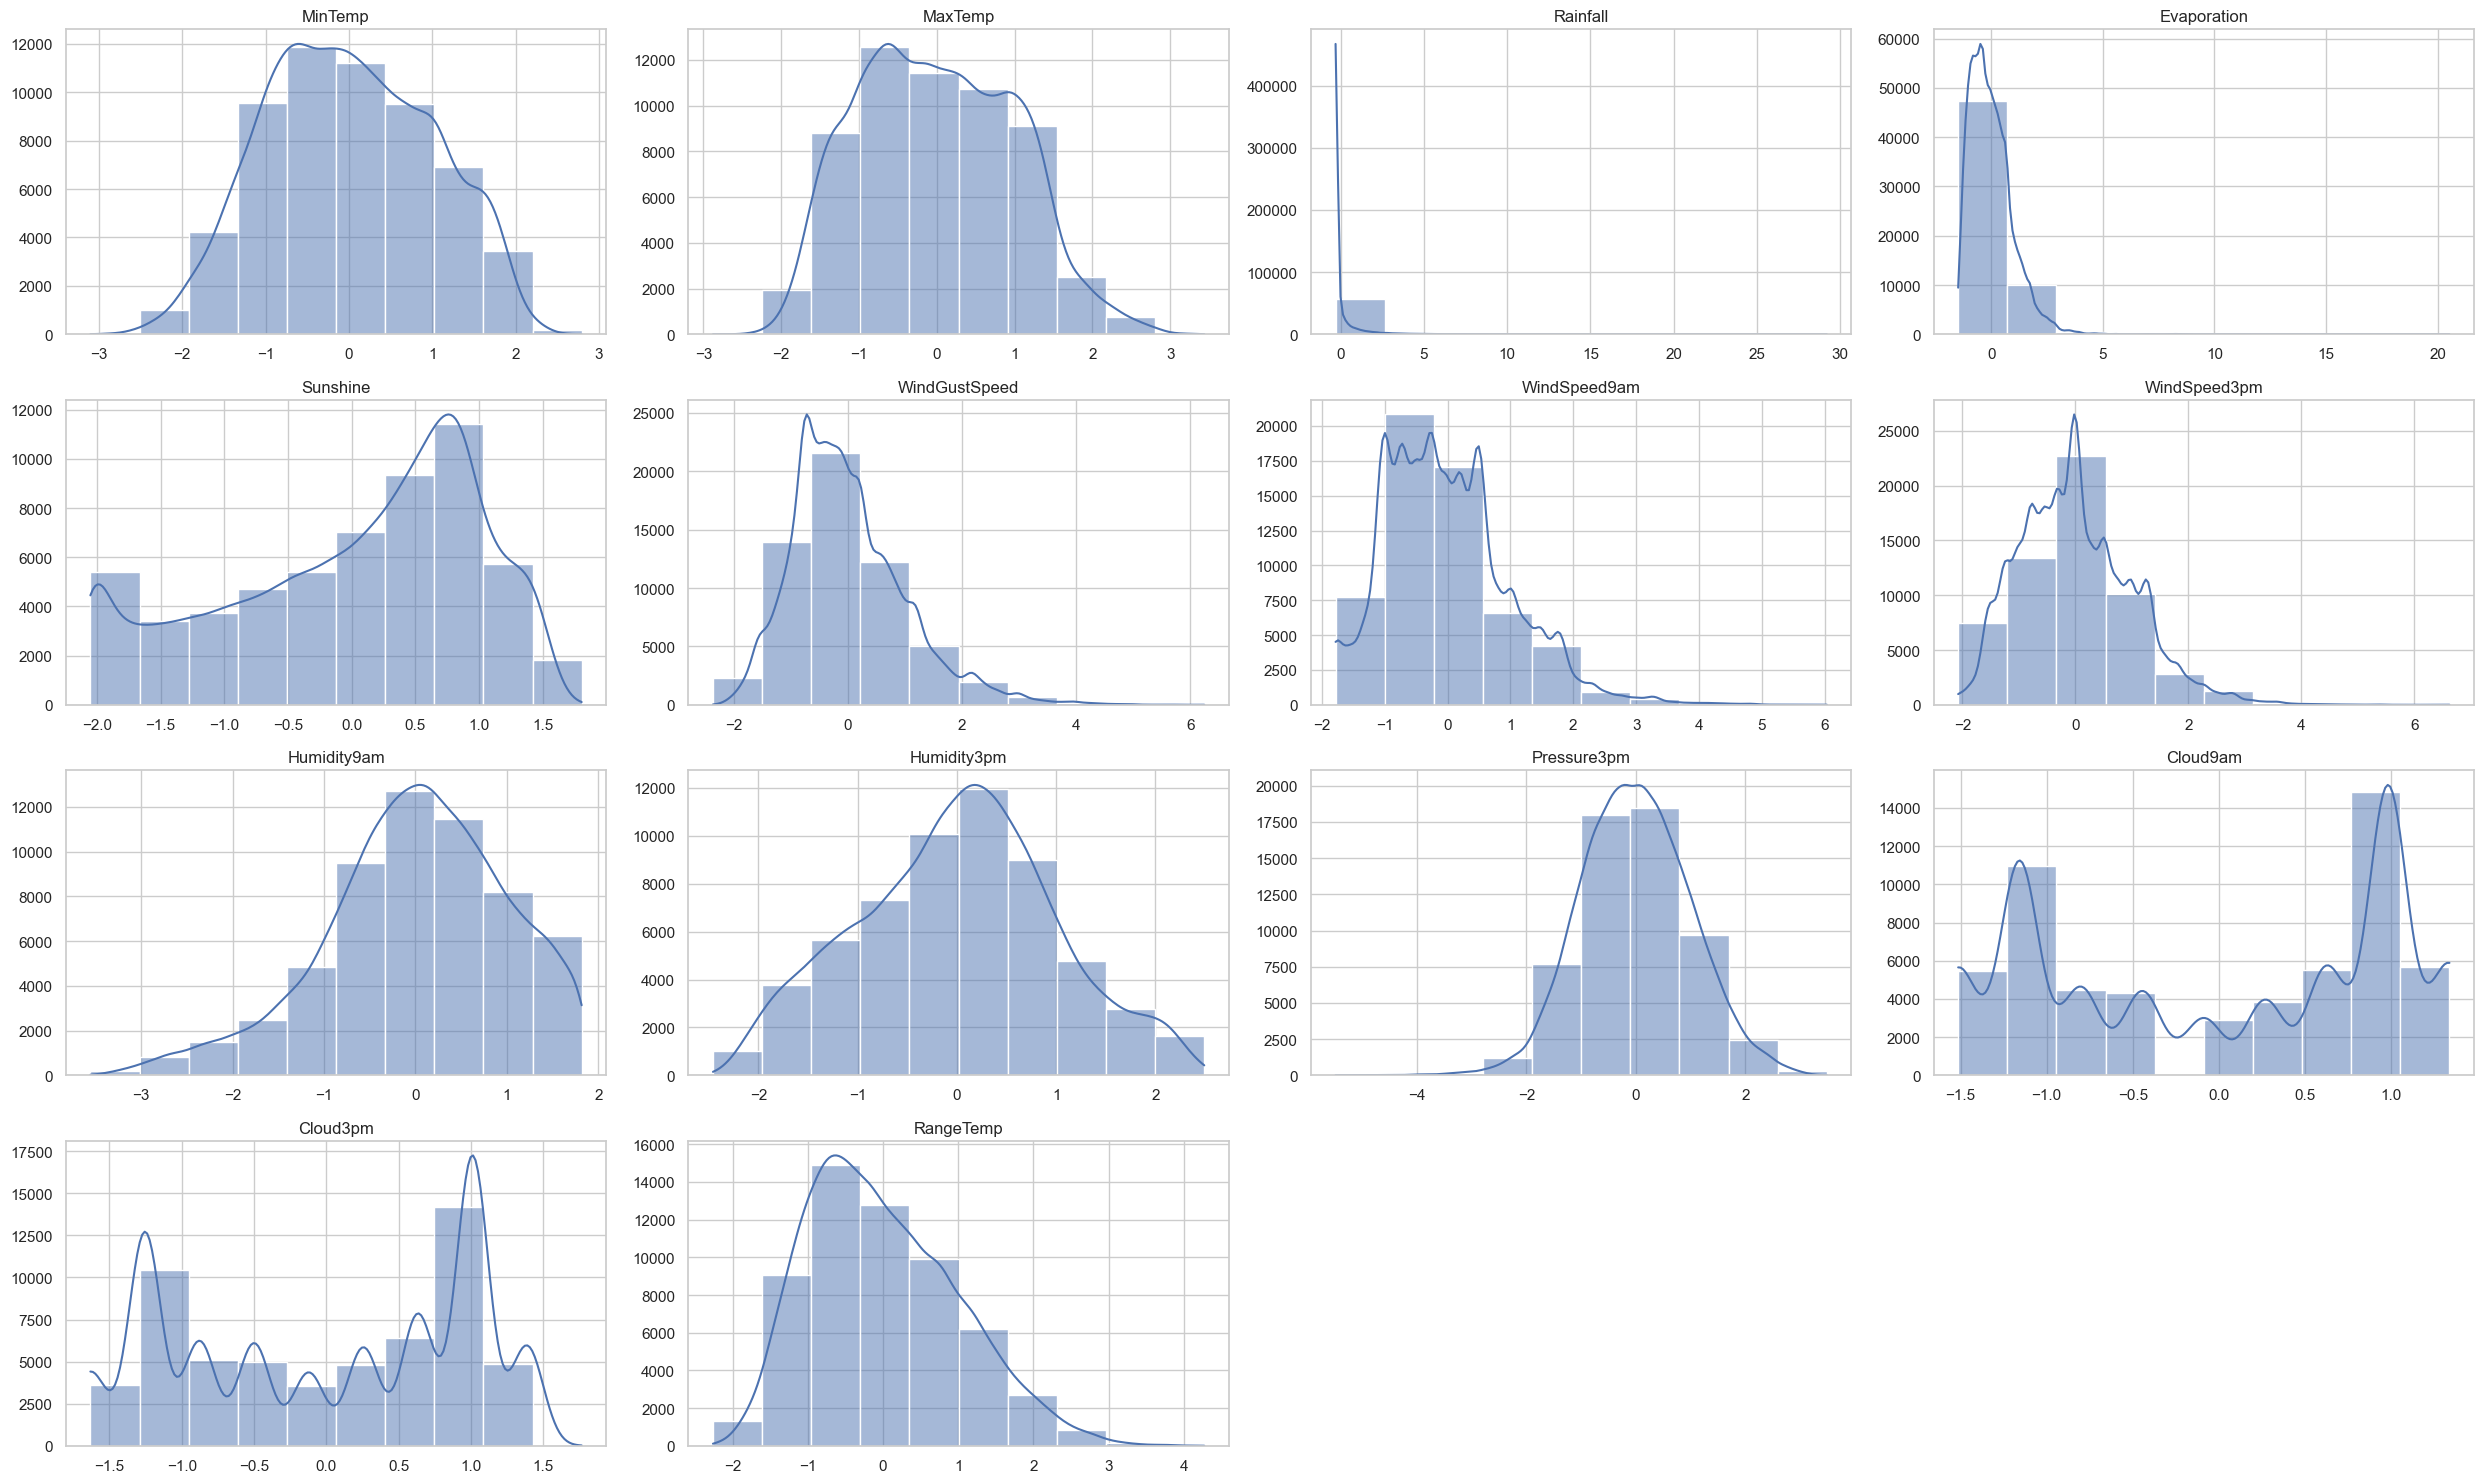

In [19]:
# Configurando o estilo do Seaborn
sns.set_theme(style="whitegrid")

# Selecionando as colunas numéricas
columns_to_plot = numerical_encoded.columns

# Definindo o número de linhas e colunas para os subplots
n_cols = 4
n_rows = len(columns_to_plot) // n_cols + (len(columns_to_plot) % n_cols > 0)

# Criando os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 15))
axes = axes.flatten()

# Plotando cada variável em um subplot
for i, col in enumerate(columns_to_plot):
    sns.histplot(numerical_encoded[col], bins=10, kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remover os subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

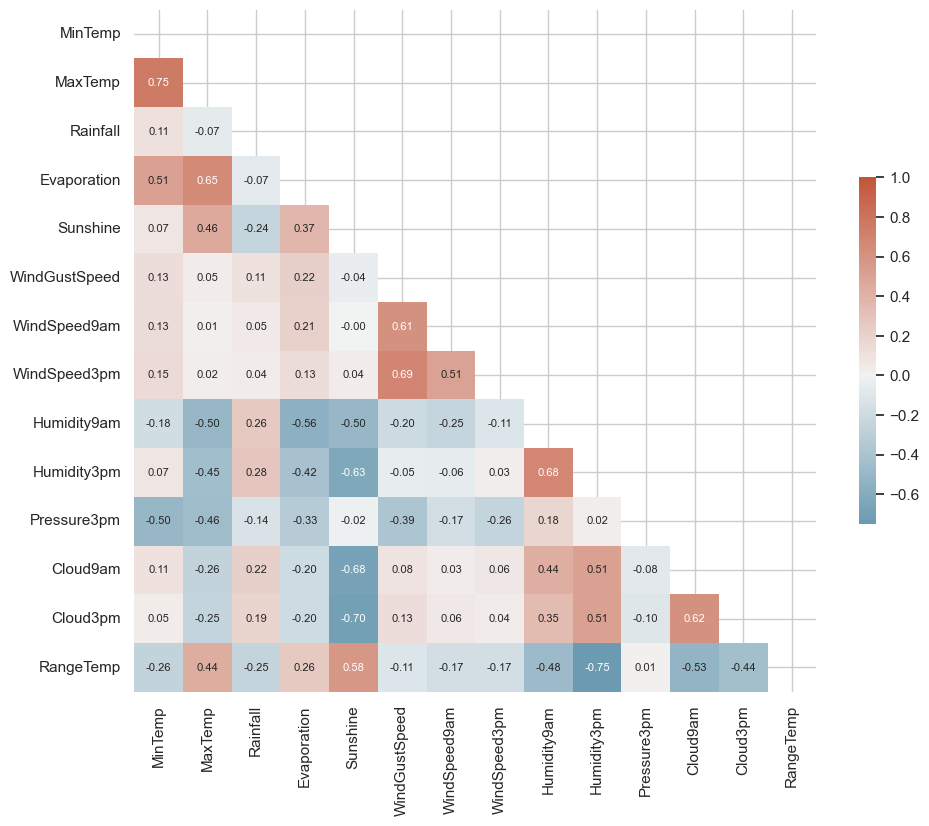

In [14]:
corr_matrix = numerical_encoded.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmax=1,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
)

plt.show();

## VARIÁVEIS TEMPORAIS

In [20]:
def get_season(month_number) -> str:
    x = month_number % 12 // 3 + 1
    if x == 1:
        return "summer"

    if x == 2:
        return "autumn"

    if x == 3:
        return "winter"

    if x == 4:
        return "spring"

In [21]:
weather["month"] = weather.Date.dt.month

In [22]:
weather["season"] = weather["month"].apply(
    lambda month_number: get_season(month_number)
)

### DUMMIES

In [23]:
time_encoded = pd.get_dummies(
    weather[["month", "season"]],
    columns=["month", "season"],
    drop_first=True,
    prefix=["month", "season"],
    dtype=int,
)

# UNIÃO DAS TRANSFORMAÇÕES

In [19]:
weather_encoded = pd.concat(
    [
        numerical_encoded,
        categorical_encoded,
        time_encoded,
        numerical_columns[["RainTomorrow", "Rainfall_Discretized"]],
    ],
    axis=1,
)

In [20]:
weather_encoded.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,month_8,month_9,month_10,month_11,month_12,season_spring,season_summer,season_winter,RainTomorrow,Rainfall_Discretized
45587,-0.827818,0.021692,-0.302874,-0.556492,-0.375197,-0.794354,-1.080874,0.041909,0.098476,-1.022077,...,0,0,0,1,0,1,0,0,1,0.0
45588,0.100365,0.394749,0.212068,-0.285588,0.529166,-0.120530,-1.314138,-0.310670,0.743134,-0.675637,...,0,0,0,1,0,1,0,0,1,0.0
45589,0.053956,-0.107444,0.212068,0.093677,-1.173164,3.323459,-1.080874,-1.603458,0.850577,0.957580,...,0,0,0,1,0,1,0,0,1,0.0
45590,-0.007923,-1.240965,5.390091,0.472942,0.369573,1.002510,1.718299,0.512013,-0.223853,0.314192,...,0,0,0,1,0,1,0,0,1,3.0
45591,-0.889696,-1.154875,0.097637,0.039496,0.768556,0.703033,0.551977,0.982118,0.098476,-0.032248,...,0,0,0,1,0,1,0,0,0,0.0


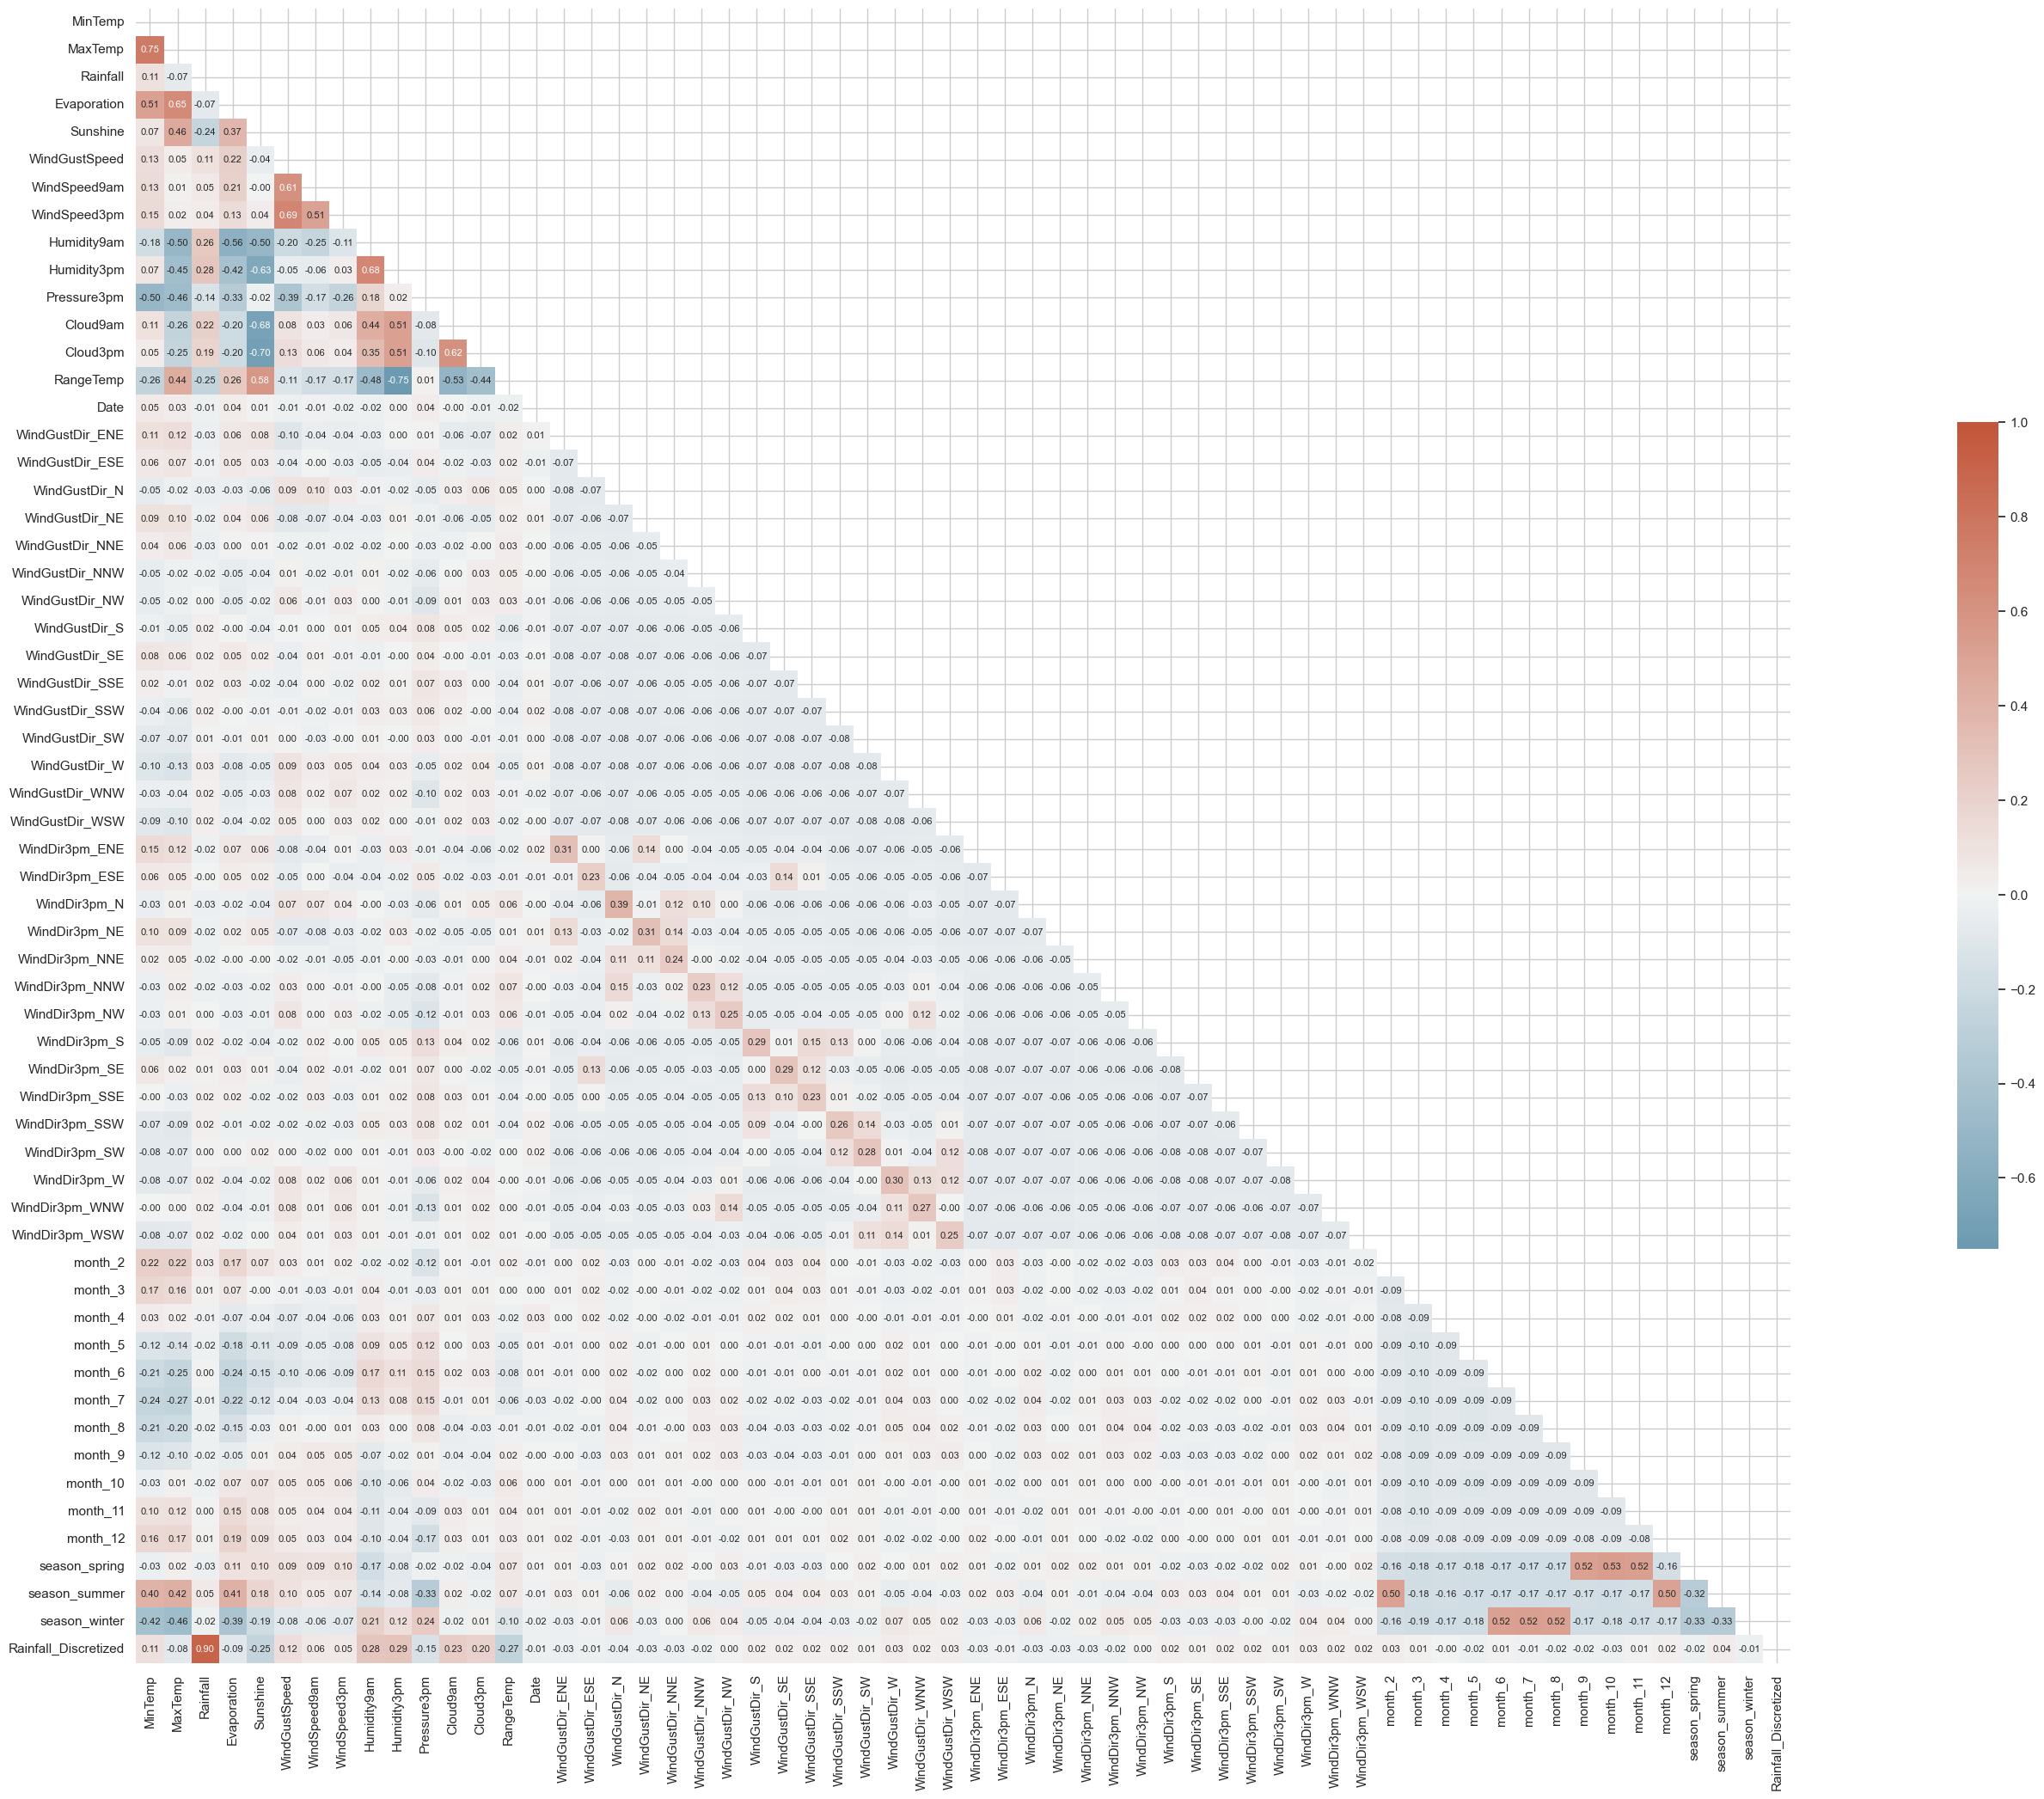

In [21]:
corr_matrix = weather_encoded[
    weather_encoded.drop(columns="RainTomorrow").columns.tolist()
].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(50, 25))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmax=1,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
)

plt.show();

# BALANCEAMENTO DE CLASSES

In [22]:
X = weather_encoded.drop(columns=["RainTomorrow", "Date"])

y = weather_encoded[["RainTomorrow"]]
y.value_counts().to_frame("QTD").reset_index()

,RainTomorrow,QTD
0,0,45253
1,1,12682


### OVERSAMPLING: SMOTE

In [23]:
SMOTE = over_sampling.SMOTE(random_state=42)
X_SMOTE, y_SMOTE = SMOTE.fit_resample(X, y)

weather_smote = pd.concat([X_SMOTE, y_SMOTE], axis=1)

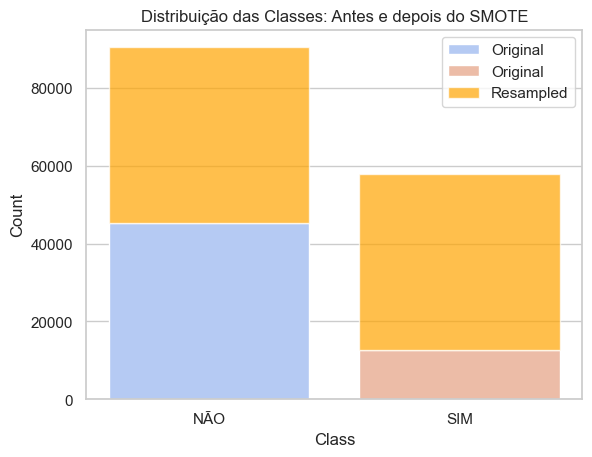

In [24]:
# Count occurrences of each class in y and y_SMOTE
y_counts = y.value_counts().sort_index()
y_SMOTE_counts = y_SMOTE.value_counts().sort_index()

# Ensure flat, unnamed indexes
y_counts.index = pd.Index(y_counts.index)
y_SMOTE_counts.index = pd.Index(y_SMOTE_counts.index)
y_counts.index.name = None
y_SMOTE_counts.index.name = None

# Create a unified index for all classes
all_classes = pd.Index(y_counts.index.union(y_SMOTE_counts.index))

# Reindex with fill_value=0
y_counts = y_counts.reindex(all_classes, fill_value=0)
y_SMOTE_counts = y_SMOTE_counts.reindex(all_classes, fill_value=0)

# Create a bar graph
fig, ax = plt.subplots()

# Plot the bars for y
sns.barplot(x=['NÃO', 'SIM'], y=y_counts.values, label='Original', palette='coolwarm', ax=ax)

# Plot the bars for y_SMOTE manually stacked
ax.bar(x=np.arange(len(all_classes)), height=y_SMOTE_counts.values, bottom=y_counts.values, label='Resampled', color='orange', alpha=0.7)

# Set the labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribuição das Classes: Antes e depois do SMOTE')
ax.set_xticks(np.arange(len(all_classes)))
ax.set_xticklabels(['NÃO', 'SIM'])
ax.legend()

# Show the plot
plt.show()


### UNDERSAMPLING: RANDOM

In [25]:
RANDOM = under_sampling.RandomUnderSampler(random_state=42)
X_RANDOM, y_RANDOM = RANDOM.fit_resample(X, y)

weather_random = pd.concat([X_RANDOM, y_RANDOM], axis=1)

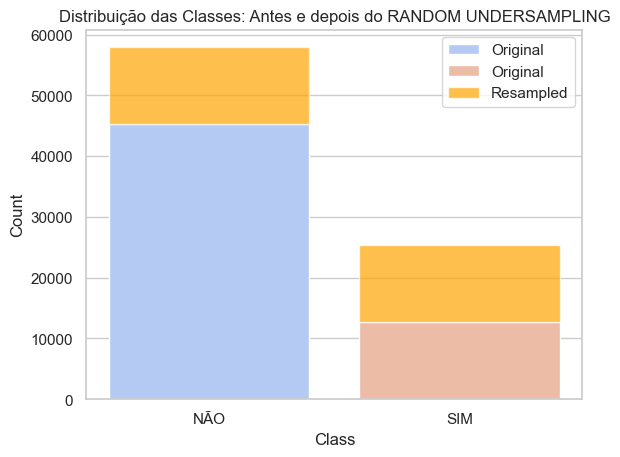

In [26]:
# Count occurrences of each class in y and y_RANDOM
y_counts = y.value_counts().sort_index()
y_RANDOM_counts = y_RANDOM.value_counts().sort_index()

# Ensure flat, unnamed indexes
y_counts.index = pd.Index(y_counts.index)
y_RANDOM_counts.index = pd.Index(y_RANDOM_counts.index)
y_counts.index.name = None
y_RANDOM_counts.index.name = None

# Create a unified index for all classes
all_classes = pd.Index(y_counts.index.union(y_RANDOM_counts.index))

# Reindex with fill_value=0
y_counts = y_counts.reindex(all_classes, fill_value=0)
y_RANDOM_counts = y_RANDOM_counts.reindex(all_classes, fill_value=0)

# Create a bar graph
fig, ax = plt.subplots()

# Plot the bars for y
sns.barplot(x=['NÃO', 'SIM'], y=y_counts.values, label='Original', palette='coolwarm', ax=ax)

# Plot the bars for y_RANDOM manually stacked
ax.bar(x=np.arange(len(all_classes)), height=y_RANDOM_counts.values, bottom=y_counts.values, label='Resampled', color='orange', alpha=0.7)

# Set the labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribuição das Classes: Antes e depois do RANDOM UNDERSAMPLING')
ax.set_xticks(np.arange(len(all_classes)))
ax.set_xticklabels(['NÃO', 'SIM'])
ax.legend()

# Show the plot
plt.show()


EXPORTAÇÃO DE BASES

In [27]:
weather_encoded.to_csv('../../DATA/weather_encoded.csv', sep='|', index=False)
weather_smote.to_csv('../../DATA/weather_smote.csv', sep='|', index=False)
weather_random.to_csv('../../DATA/weather_random.csv', sep='|', index=False)

# FEATURE SELECTION

In [2]:
weather_encoded = pd.read_csv('../../DATA/weather_encoded.csv', sep='|')
weather_smote = pd.read_csv('../../DATA/weather_smote.csv', sep='|')
weather_random = pd.read_csv('../../DATA/weather_random.csv', sep='|')

In [3]:
X = weather_encoded.drop(columns=['RainTomorrow', 'Date'])
y = weather_encoded['RainTomorrow']

## FILTRO: CORRELAÇÃO (CFS)

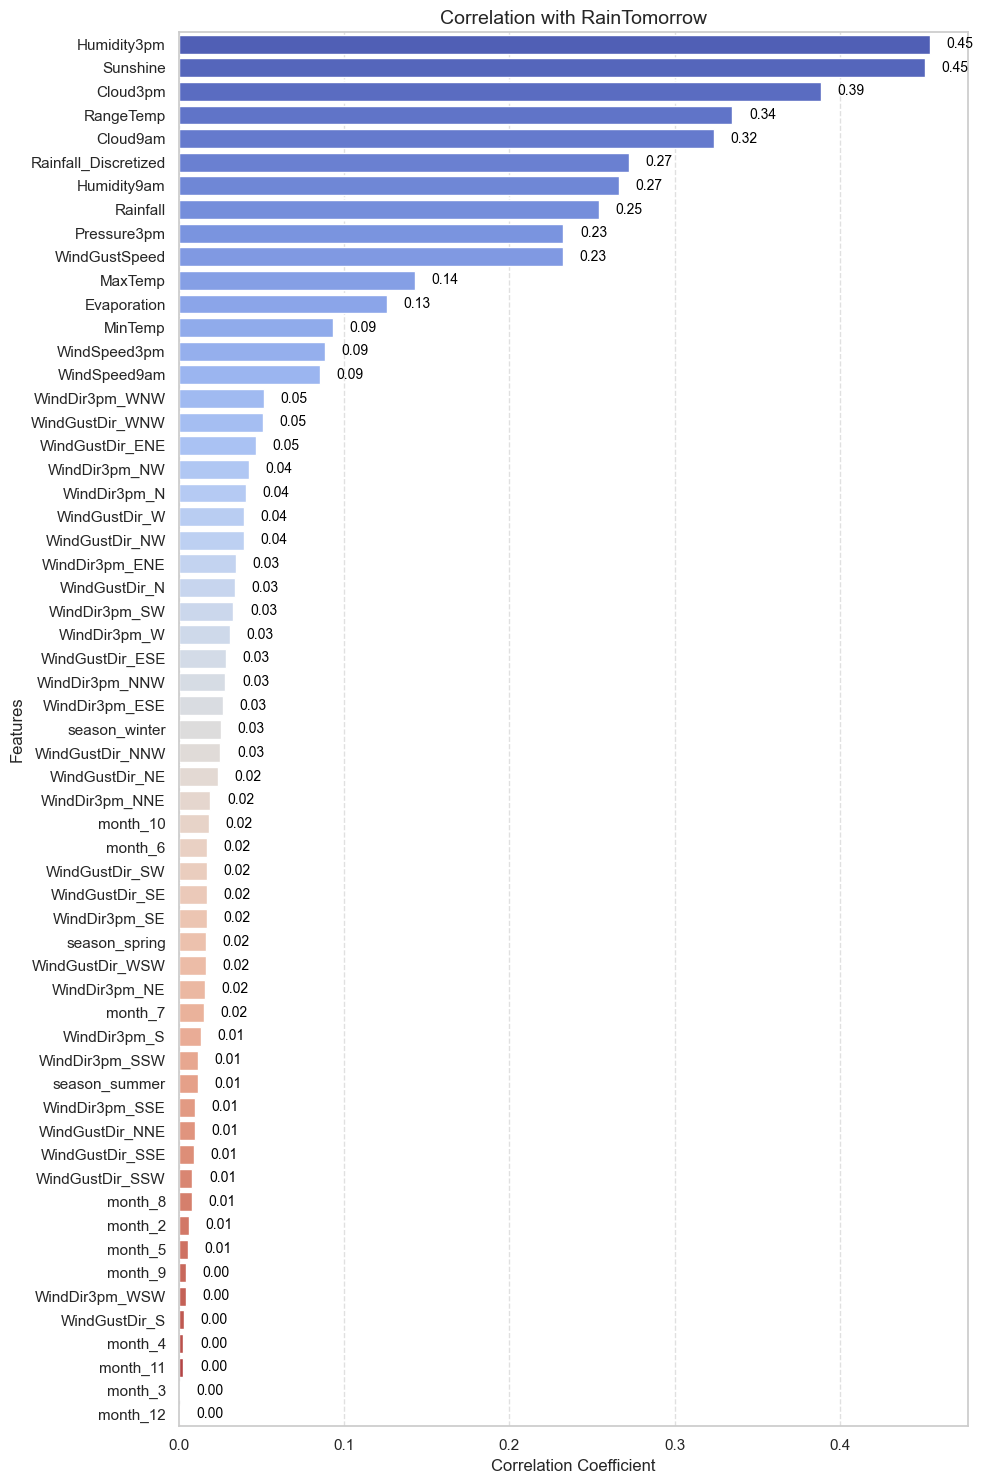

In [80]:
# Calcular a correlação entre características e a variável alvo
correlations = X.corrwith(y).abs()

corr_graph = correlations.sort_values(ascending=False)
# Plot the correlations as a bar chart with correlation values
plt.figure(figsize=(10, 15))
ax = sns.barplot(y=corr_graph.index, x=corr_graph.values, palette='coolwarm')

# Add correlation values to the bars
for bar, corr in zip(ax.patches, corr_graph.values):
    plt.text(
        bar.get_width() + 0.01,  # Position slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically center the text
        f'{corr:.2f}',  # Format the correlation value
        va='center', fontsize=10, color='black'
    )

# Add labels and title
plt.title('Correlation with RainTomorrow', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [81]:
# Definir um limiar de correlação (ajuste conforme necessário)
correlation_threshold = 0.3
important_features = correlations[correlations > correlation_threshold].index

# Filtrar características altamente correlacionadas
correlation_matrix = X[important_features].corr().abs()
upper_triangle = np.triu(correlation_matrix, k=1)
to_drop = [column for column in correlation_matrix.columns if any(upper_triangle[correlation_matrix.columns.get_loc(column)] > 0.9)]

# Remover características redundantes
selected_features = [column for column in important_features if column not in to_drop]
X_filtered = X[selected_features]

print(f"{len(selected_features)} Características selecionadas:")
print(selected_features)


5 Características selecionadas:
['Sunshine', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'RangeTemp']


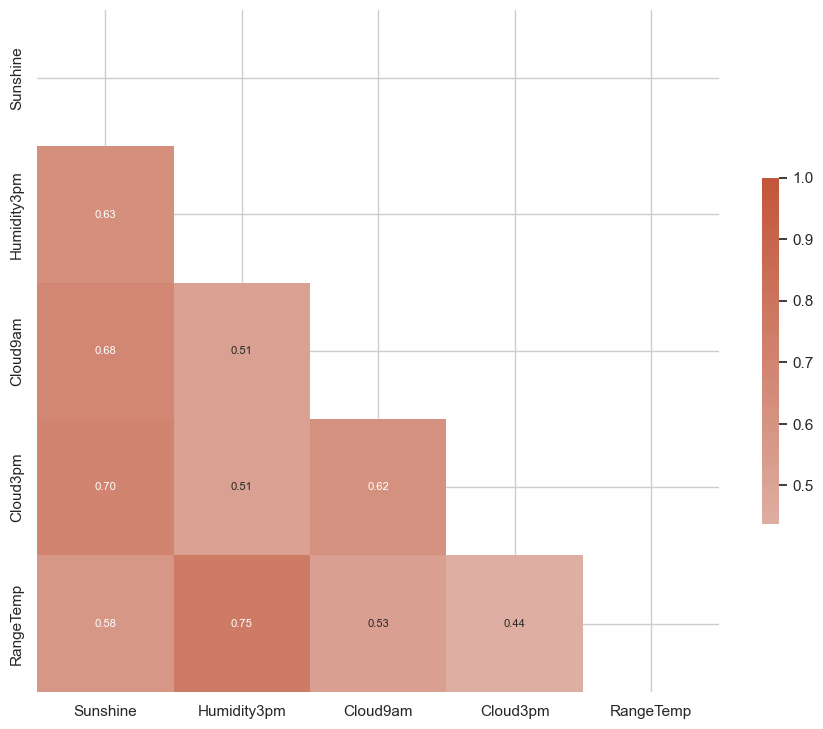

In [82]:
corr_matrix = correlation_matrix.copy()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
            annot_kws={"size": 8})  # Reduzindo o tamanho da fonte para 8

plt.show()

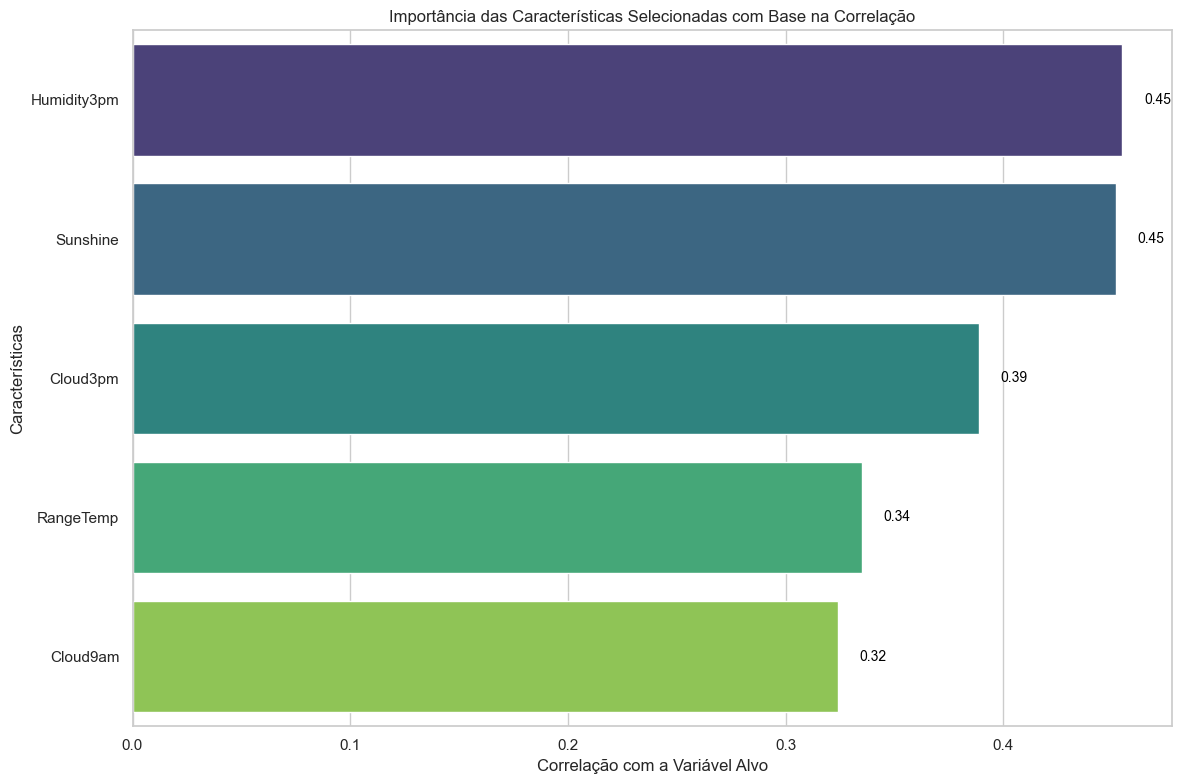

In [ ]:
# Plot the feature importances as a bar chart with correlation values
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=feature_importance.values,
    y=feature_importance.index,
    hue=feature_importance.index,
    palette='viridis'
)

# Add correlation values to the bars
for bar, corr in zip(ax.patches, feature_importance.values):
    plt.text(
        bar.get_width() + 0.01,  # Position slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically center the text
        f'{corr:.2f}',  # Format the correlation value
        va='center', fontsize=10, color='black'
    )

# Add labels and title
plt.title('Importância das Características Selecionadas com Base na Correlação')
plt.xlabel('Correlação com a Variável Alvo')
plt.ylabel('Características')
plt.tight_layout()
plt.show()


## ÁRVORES DE DECISÃO: RANDOM FOREST

In [6]:
# Criar o modelo RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Obter importâncias das características
importances = model.feature_importances_
features = X.columns

# Criar um DataFrame com as importâncias e os resultados
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False, ignore_index=True)

# Exibir as características e suas importâncias
print("Top 10 Feature Importances - RandomForestClassifier:")
importances_df.loc[:14]


Top 10 Feature Importances - RandomForestClassifier:


,Feature,Importance
0,Humidity3pm,0.146353
1,Sunshine,0.098897
2,Pressure3pm,0.075073
3,Cloud3pm,0.059159
4,RangeTemp,0.058279
5,WindGustSpeed,0.057975
6,Humidity9am,0.050518
7,Rainfall,0.048255
8,MinTemp,0.046893
9,MaxTemp,0.046834


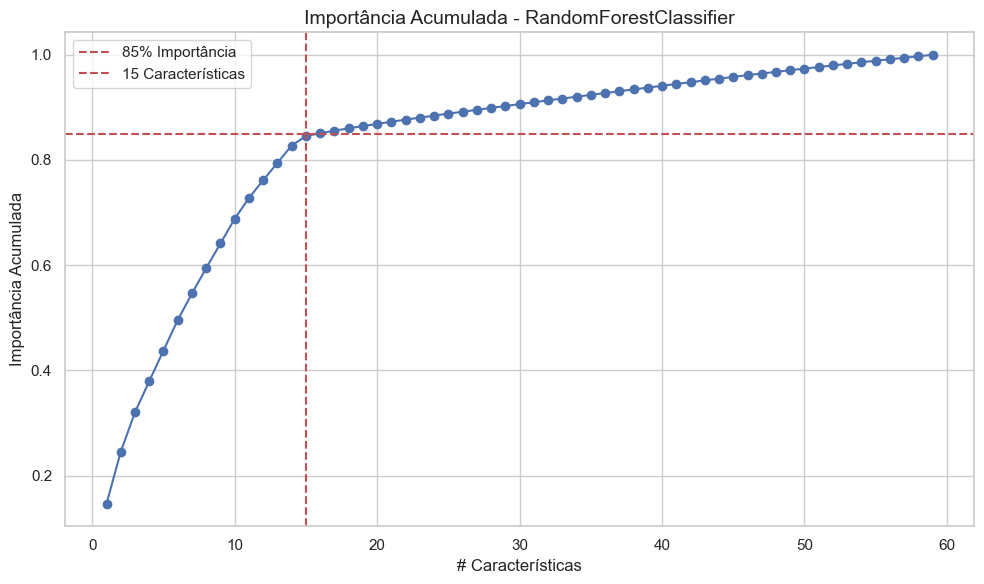

In [57]:
# Calculate cumulative sum of feature importances
importances_df['Cumulative Importance'] = importances_df['Importance'].cumsum()
importances_df['Feature Count'] = range(1, len(importances_df) + 1)

# Plot cumulative importance vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(importances_df['Feature Count'], importances_df['Cumulative Importance'], marker='o', linestyle='-', color='b')

# Add horizontal line at 0.95 to show 95% cumulative importance
plt.axhline(y=0.85, color='r', linestyle='--', label='85% Importância')
plt.axvline(x=15, color='r', linestyle='--', label='15 Características')

# Add labels and title
plt.title('Importância Acumulada - RandomForestClassifier', fontsize=14)
plt.xlabel('# Características', fontsize=12)
plt.ylabel('Importância Acumulada', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
importances_df['Importance Difference'] = round(importances_df['Importance'].diff(), 5) * 100
importances_df.loc[:14]

,Feature,Importance,Cumulative Importance,Feature Count,Importance Difference
0,Humidity3pm,0.146353,0.146353,1,NaN
1,Sunshine,0.098897,0.245250,2,-4.746
2,Pressure3pm,0.075073,0.320323,3,-2.382
3,Cloud3pm,0.059159,0.379482,4,-1.591
4,RangeTemp,0.058279,0.437761,5,-0.088
5,WindGustSpeed,0.057975,0.495735,6,-0.030
6,Humidity9am,0.050518,0.546253,7,-0.746
7,Rainfall,0.048255,0.594508,8,-0.226
8,MinTemp,0.046893,0.641401,9,-0.136
9,MaxTemp,0.046834,0.688234,10,-0.006


In [8]:
# Selecionar características com base na importância
selector = SelectFromModel(model, threshold='mean', prefit=True)
X_new = selector.fit_transform(X)

# Características selecionadas
print("SelectFromModel - Características Selecionadas:")
selector.get_feature_names_out().tolist()

SelectFromModel - Características Selecionadas:


['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'RangeTemp',
 'Rainfall_Discretized']

## PCA

In [28]:
# Aplicar PCA
pca = PCA()
pca.fit(numerical_encoded)

components = pca.components_

# Criar um DataFrame para os componentes principais
components_df = pd.DataFrame(components, columns=numerical_encoded.columns.to_list(), index=[f'PC{i+1}' for i in range(components.shape[0])])

# Obter a variância explicada
explained_variance = pca.explained_variance_ratio_
explained_variance_cumulative = explained_variance.cumsum()

# Criar um DataFrame para a variância
variance_df = pd.DataFrame({
    'Autovalor': pca.explained_variance_,
    'Proporção da Variância': explained_variance,
    'Variância Acumulada': explained_variance_cumulative
}, index=[f'PC{i+1}' for i in range(len(explained_variance))])

# Exibir resultados
print("Cargas dos Componentes Principais:")
components_df



Cargas dos Componentes Principais:


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RangeTemp
PC1,-0.104192,-0.332312,1.480624e-01,-2.980557e-01,-3.870672e-01,-3.593943e-02,-4.168730e-02,-2.288688e-02,3.667028e-01,3.911953e-01,9.292028e-02,3.233699e-01,3.093026e-01,-0.343808
PC2,0.379939,0.208216,1.519573e-01,2.536679e-01,-1.062234e-01,4.193473e-01,3.487983e-01,3.681174e-01,-9.548313e-02,9.356591e-02,-3.821121e-01,1.915310e-01,1.890486e-01,-0.210340
PC3,0.456629,0.393646,1.168944e-01,1.799375e-01,-5.888330e-02,-4.005530e-01,-4.099798e-01,-4.042767e-01,9.129310e-02,1.209550e-01,-2.047872e-01,1.369795e-01,9.742331e-02,-0.043596
PC4,0.087540,-0.016356,6.765527e-01,-1.461571e-01,2.830818e-01,2.329879e-03,-2.773138e-02,1.341729e-01,2.666947e-01,1.700462e-01,-4.380154e-02,-3.154054e-01,-4.386095e-01,-0.142311
PC5,-0.337207,0.003773,5.785364e-01,-1.758986e-02,-1.859775e-01,1.462273e-01,-9.728963e-02,-1.597586e-01,-9.370237e-02,-2.864150e-01,-2.427252e-01,1.232018e-01,2.866345e-01,0.461777
PC6,0.088466,-0.044862,3.469845e-01,3.446976e-01,-8.716648e-02,-1.577825e-01,4.203790e-01,-2.821731e-01,-2.664286e-01,-8.372715e-02,5.875996e-01,5.772038e-02,3.511999e-02,-0.185149
PC7,0.027209,0.147037,7.788316e-02,2.327138e-01,8.319961e-02,4.656858e-02,-3.857143e-01,5.182258e-01,2.205518e-01,-1.207100e-01,4.746680e-01,4.119482e-01,-3.458599e-02,0.177687
PC8,0.006632,0.015351,-4.311982e-02,-2.140008e-01,5.876442e-02,-8.927855e-02,3.121680e-01,-1.827279e-01,1.352451e-01,-2.678219e-01,-1.814353e-01,6.530660e-01,-5.100868e-01,0.013422
PC9,-0.226761,-0.422056,6.190467e-03,5.338513e-01,-8.758755e-02,1.103433e-01,-3.774872e-01,-6.908628e-02,-2.128921e-01,1.931415e-02,-2.435892e-01,1.077314e-01,-3.259602e-01,-0.308882
PC10,-0.173071,0.006232,-1.273232e-01,5.068028e-01,9.371332e-02,1.173538e-01,2.731918e-01,-2.339045e-01,6.693057e-01,1.602864e-01,-4.784607e-02,-9.345291e-02,3.438951e-02,0.243271


In [29]:
print("Variância Explicada por Componente Principal:")
variance_df

Variância Explicada por Componente Principal:


,Autovalor,Proporção da Variância,Variância Acumulada
PC1,4.552435,0.325168,0.325168
PC2,2.975400,0.212525,0.537693
PC3,1.779295,0.127090,0.664784
PC4,0.946399,0.067599,0.732382
PC5,0.838022,0.059858,0.792240
PC6,0.692946,0.049495,0.841735
PC7,0.475179,0.033941,0.875676
PC8,0.381513,0.027250,0.902926
PC9,0.375574,0.026826,0.929753
PC10,0.334611,0.023900,0.953653


In [31]:
# Calcular a variância acumulada
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

# Criar o gráfico de área
fig = px.area(
    x=range(1, len(exp_var_cumul) + 1),
    y=exp_var_cumul,
    labels={"x": "# Componentes", "y": "Variação Explicada Acumulada"},
    title="Variação Explicada Acumulada pelos Componentes Principais"
)

# Exibir o gráfico
fig.show()

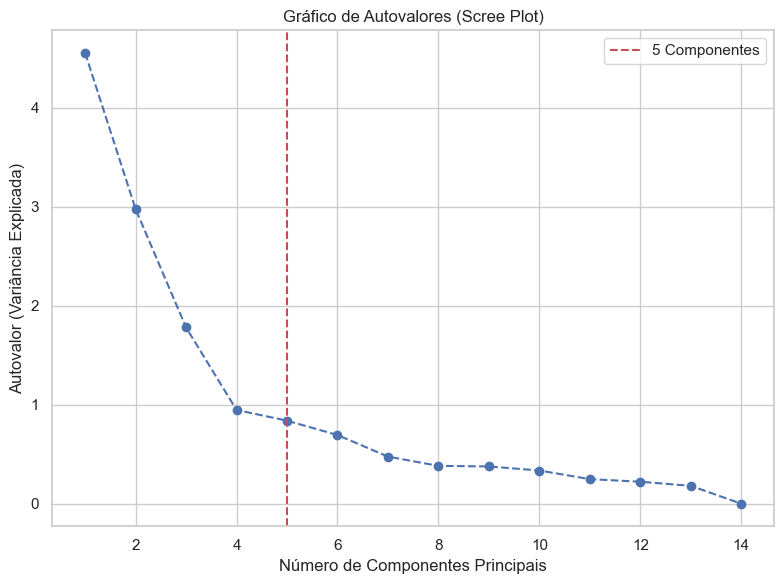

In [36]:
# Extrair autovalores (variância explicada por componente)
eigenvalues = pca.explained_variance_

# Gerar gráfico de autovalores (gráfico "scree")
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--', color='b')
plt.axvline(x=5, color='r', linestyle='--', label='5 Componentes')
plt.title('Gráfico de Autovalores (Scree Plot)')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Autovalor (Variância Explicada)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# Converter range para lista
componentes = list(range(1, len(exp_var_cumul) + 1))

# Criar o gráfico de barras e linha
fig = go.Figure()

# Adicionar a linha da variação acumulada
fig.add_trace(go.Scatter(
    x=componentes,
    y=exp_var_cumul,
    mode='lines+markers',
    name='Variação Acumulada',
    line=dict(color='royalblue')
))

# Adicionar as barras da variância explicada
fig.add_trace(go.Bar(
    x=componentes,
    y=pca.explained_variance_ratio_,
    name='Variação Explicada por Componente',
    marker_color='lightcoral'
))

# Configurar o layout do gráfico
fig.update_layout(
    title="Variação Explicada Acumulada pelos Componentes Principais",
    xaxis_title="# Componentes",
    yaxis_title="Variação Explicada",
    barmode='overlay'
)

# Exibir o gráfico
fig.show()